### TO DO:

- All of the text can be edited and rewritten
- Add links/citations
- Check on the empirical targets, both in the CSTW paper/code/repo and recent measurements from the literature


# The Distribution of Wealth and the MPC

This notebook presents an analogous selection of results from the paper [The Distribution of Wealth and the Marginal Propensity to Consume](http://econ.jhu.edu/people/ccarroll/papers/cstwMPC), using the [Econ-ARK/HARK](https://github.com/econ-ark/HARK) toolkit. In this version of the model, the results are presented for the estimation procedure with the **rate of return** as the key parameter of interest. 

In [1]:
# This cell does some standard python setup!

import code.calibration as parameters
import warnings  # The warnings package allows us to ignore some harmless but alarming warning messages
from code.calibration import SCF_wealth, SCF_weights
from code.estimation import estimate

# Import related generic python packages
import matplotlib.pyplot as plt  # Plotting tools
import numpy as np
from HARK.utilities import get_lorenz_shares

warnings.filterwarnings("ignore")


def mystr(number):
    return f"{number:.4f}"

## Contributions from the CSTW paper

### Heterogeneous Time Preferences

In a model calibrated to match micro- and macroeconomic evidence on household income dynamics, (cite the CSTW paper) shows that a modest degree of heterogeneity in household preferences or beliefs is sufficient to match empirical measures of wealth inequality in the U.S. 

In cstwMPC, the authors calibrated nearly all of the model parameters-- risk aversion, income shock process, etc-- to commonly used or previously estimated values.  The only parameter to be estimated is the distribution of $\beta$.  cstwMPC assumed that $\beta$ is uniformly distributed on $[\grave{\beta}-\nabla,\grave{\beta}+\nabla]$, approximated by a seven point distribution.

### Empirical Wealth Targets

Their estimation procedure seeks the values of $\grave{\beta}$ and $\nabla$ that generate a simulated distribution of wealth that best matches empirical U.S. data.  Their definition of "best match" has two aspects:

1. The simulated aggregate capital-to-income ratio matches the true U.S. value.
2. The sum of squared distances between the simulated and empirical Lorenz curves (at the 20th, 40th, 60th, and 80th percentiles) is minimized (conditional on item 1).

cstwMPC's target empirical moments are a capital-to-income ratio of 10.26 and cumulative wealth shares as given in the table below.  Yes, you are reading the table correctly: The "poorest" 80 percent of households own 17.5 percent of wealth.

| Net worth percentile | Cumulative wealth share |
|:---:|:---:|
|  20th  | -0.2% |
|  40th  | 1.0% |
|  60th  | 5.5% |
|  80th  | 17.5% |

For a description of the relevant notation and the optimization problem that households solve, see (Link to the CSTW notebook). Importantly, the estimation procedure in this paper will use the same empirical targets as those presented there.

## Heterogeneous Rates of Return

### Theoretical Motivation 

As discussed in the DemARK (link to Micro-and-Macro-Implications...), Buffer stock saving models of the kind implemented in $\texttt{ConsIndShockType}$ say that, if a standard ['Growth Impatience Condition'](https://econ-ark.github.io/BufferStockTheory/#GICRaw), holds:

\begin{eqnarray}
\newcommand{\Rfree}{\mathsf{R}}\newcommand{\DiscFac}{\beta}\newcommand{\PermGroFac}{\Gamma}\newcommand{\PermShk}{\psi}\newcommand{\CRRA}{\rho}
\left(\frac{(\Rfree\DiscFac)^{1/\CRRA}\mathbb{E}[\PermShk^{-1}]}{\PermGroFac}\right) & < & 1
\end{eqnarray}

then the _ratio_ of asets $\newcommand{\aLev}{\mathbf{a}}\aLev$ to permanent income $\newcommand{\pLev}{\mathbf{p}}\pLev$, $a=\aLev/\pLev$, has a target value $\newcommand{\aTarg}{\check{a}}\aTarg$ that depends on the consumer's preferences (relative risk aversion $\CRRA$, time preference $\DiscFac$) and circumstances (interest factor $\Rfree$, growth factor $\PermGroFac$, uncertainty about permanent income shocks $\sigma^{2}_{\PermShk}$).

If everyone had identical preferences and everyone were at their target $\check{a}$, then inequality in the level of $\aLev$ would be exactly the same as inequality in $\pLev$. 

Moreover, since each of the parameters featured in this Growth Impatience Condition capture aspects of the household's optimal consumption-savings behavior, the assumption that households differ significantly in the value of one or many of these variables can potentially explain disparities in wealth accumulation over the life-cycle.

### Empirical Evidence 

It is worth noting that the time preference factor $(\beta)$ is one of the key parameters that influences an individual's equilibrium target level of market resources, but it is not directly observable. Therefore, in order to estimate $\beta$, one would need to gather data through surveys or other methods that allow for the direct acquisition of information from households.

On the other hand, estimating differences in the rate of return $(\Rfree)$ to financial assets across households is possible, as this variable *is* directly observable. Recent empirical recent has exploited the usefulness novel, administrative and survey datasets on household asset holdings in an attempt to quantify the differences in returns among individuals. These datasets are "novel" in the sense that they are more representative of household finances than their U.S. counterparts, which are known to suffer from substantial measurement bias, especially at the top end of the wealth distribution. 

Among these recent empirical efforts are the following notable contributions (provide actual citation/links for each of these):

1. Do the Rich Get Richer in the Stock Market? Evidence from India
2. Financial Literacy and Savings Account Returns
3. Rich Pickings? Risk, Return, and Skill in Household Wealth
4. Heterogeneity and Persistence in Returns to Wealth

Not only do each of these papers provide motivation for the estimation of a buffer-stock savings model with ex-ante heterogeneity in the rate of return, but they also offer a baseline for evaluating the results of the procedure. That is, the distribution of rates of return which are produced in this notebook should be "close" to the empirical estimates presented in these papers.

*In this notebook, the notion of "closeness" will be a graphical comparison. However, it is clear that a more mathematical description can be presented (much as the distance between the simulated and empirical Lorenz points are minimized).* (-revise this, could be said much better!)

## Goals of this Notebook

* Run the simplest specification of the estimation for Rfree
* Compare the results to CSTW... how "close" are the Lorenz sim points to the empirical counterpart?
* Compare the estimated distribution of Rfree to the "empirical counterpart" regarding heterogeneous returns, from the four empirical papers listed above

In [2]:
"""
This will run the absolute minimum amount of work that actually produces
relevant output-- no aggregate shocks, perpetual youth, matching net worth.
Will run both beta-point and beta-dist versions.
"""

"""
Copied here from do_min.py.
Design decisions about whether to include this code explicitly,
or import it, or execute it as is here, TBD.
"""

'\nCopied here from do_min.py.\nDesign decisions about whether to include this code explicitly,\nor import it, or execute it as is here, TBD.\n'

In [3]:
# For speed here, use the "tractable" version of the model
# This is not the "right" model, but illustrates the key point
"""
This options file specifies parameter heterogeneity, making the choice in the paper:
uniformly distributed discount factors.
"""
param_name = "Rfree"  # Which parameter to introduce heterogeneity in
dist_type = "uniform"  # Which type of distribution to use

"""
This options file specifies the "standard" work options for cstwMPC, estimating the model only.
"""
run_estimation = True  # Runs the estimation if True
# Choose which sensitivity analyses to run: rho, xi_sigma, psi_sigma, mu, urate, mortality, g, R
run_sensitivity = [False, False, False, False, False, False, False, False]
# Computes K/Y ratio for a wide range of beta; should have do_beta_dist = False
find_beta_vs_KY = False
# Uses a "tractable consumer" rather than solving full model when True
do_tractable = True

# Solve for the $\beta-Point$ (do_param_dist=False) for speed
"""
This options file establishes the second simplest model specification possible:
with heterogeneity, no aggregate shocks, perpetual youth model, matching net worth.
"""

do_param_dist = False  # Do param-dist version if True, param-point if False
do_lifecycle = False  # Use lifecycle model if True, perpetual youth if False
do_agg_shocks = False  # Solve the FBS aggregate shocks version of the model
# Matches liquid assets data when True, net worth data when False
do_liquid = False

Beginning an estimation with the specification name PYUnifrratePointIndNetWorth...
1.0063522012578616
get_KY_ratio_difference tried center = 1.0063522012578616 and got -9.046227489836356
1.1163522012578617
get_KY_ratio_difference tried center = 1.1163522012578617 and got 746057147403175.0
1.006352201257863
get_KY_ratio_difference tried center = 1.006352201257863 and got -9.046227489836253
1.0337796448321375
get_KY_ratio_difference tried center = 1.0337796448321375 and got 1220.762277465089
1.0067557029299328
get_KY_ratio_difference tried center = 1.0067557029299328 and got -9.014332312183996
1.0135929919005524
get_KY_ratio_difference tried center = 1.0135929919005524 and got -6.004547465213422
1.0137906035627333
get_KY_ratio_difference tried center = 1.0137906035627333 and got -5.554310438779648
1.0237851241974354
get_KY_ratio_difference tried center = 1.0237851241974354 and got 92.2824628577587
1.0161057505140334
get_KY_ratio_difference tried center = 1.0161057505140334 and got 3.5669

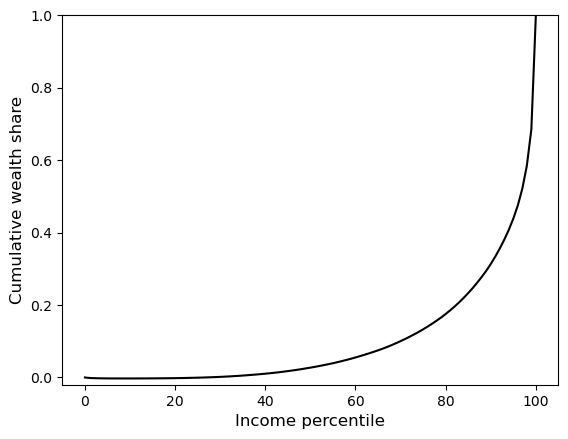

Estimate is center=1.0153576975671124, spread=0.0
Lorenz distance is 42.485036731314125
Average MPC for all consumers is 0.095
Average MPC in the top percentile of W/Y is 0.065
Average MPC in the top decile of W/Y is 0.068
Average MPC in the top quintile of W/Y is 0.069
Average MPC in the second quintile of W/Y is 0.071
Average MPC in the middle quintile of W/Y is 0.071
Average MPC in the fourth quintile of W/Y is 0.073
Average MPC in the bottom quintile of W/Y is 0.193
Average MPC in the top percentile of y is 0.072
Average MPC in the top decile of y is 0.074
Average MPC in the top quintile of y is 0.081
Average MPC in the second quintile of y is 0.113
Average MPC in the middle quintile of y is 0.115
Average MPC in the fourth quintile of y is 0.079
Average MPC in the bottom quintile of y is 0.089
Average MPC for the employed is 0.093
Average MPC for the unemployed is 0.127
Average MPC for the retired is nan
Of the population with the 1/3 highest MPCs...
62.801% are in the bottom wealt

In [4]:
options = {
    "param_name": param_name,
    "dist_type": dist_type,
    "run_estimation": run_estimation,
    "run_sensitivity": run_sensitivity,
    "find_beta_vs_KY": find_beta_vs_KY,
    "do_tractable": do_tractable,
    "do_param_dist": do_param_dist,
    "do_lifecycle": do_lifecycle,
    "do_agg_shocks": do_agg_shocks,
    "do_liquid": do_liquid,
}


EstimationEconomy = estimate(options, parameters)

In [5]:
MyGuys = EstimationEconomy.agents[0]
MyGuys.check_conditions()
print(MyGuys.bilt["conditions_report"])

β=0.99000 : intertemporal discount factor (DiscFac)
R=1.01536 : risk free interest factor (Rfree)
G=1.00000 : permanent income growth factor (PermGroFac)
ρ=1.01000 : coefficient of relative risk aversion (CRRA)
ℒ=0.99375 : survival probability (LivPrb)
Þ=(βℒR)^(1/ρ)=0.99893 : absolute patience factor (APFac)
℘=0.01400 : probability of worst income shock realization (WorstPrb)

APFac=0.99893 : The Absolute Patience Factor satisfies the Absolute Impatience Condition (AIC) Þ < 1.
RPFac=0.98382 : The Return Patience Factor satisfies the Return Impatience Condition (RIC) Þ/R < 1.
WRPFac=0.01437 : The Weak Return Patience Factor satisfies the Weak Return Impatience Condition (WRIC) ℘ Þ/R < 1.
GPFacRaw=0.99893 : The Growth Patience Factor satisfies the Growth Impatience Condition (GICRaw) Þ/G < 1.
GPFacMod=1.00220 : The Risk-Modified Growth Patience Factor violates the Risk-Modified Growth Impatience Condition (GICMod) Þ/(G‖Ψ‖_(-1)) < 1.
GPFacLiv=0.99269 : The Mortality-Adjusted Growth Patien

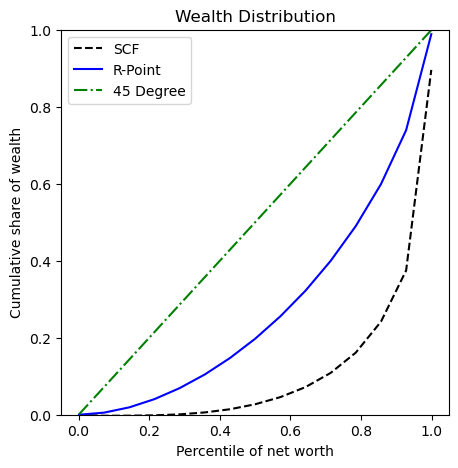

In [6]:
# Construct the Lorenz curves and plot them

pctiles = np.linspace(0.001, 0.999, 15)
SCF_Lorenz_points = get_lorenz_shares(
    SCF_wealth, weights=SCF_weights, percentiles=pctiles
)

sim_wealth = EstimationEconomy.reap_state["aLvl"][0]
sim_Lorenz_points = get_lorenz_shares(sim_wealth, percentiles=pctiles)

# Plot
plt.figure(figsize=(5, 5))
plt.title("Wealth Distribution")
plt.plot(pctiles, SCF_Lorenz_points, "--k", label="SCF")
plt.plot(pctiles, sim_Lorenz_points, "-b", label="R-Point")
plt.plot(pctiles, pctiles, "g-.", label="45 Degree")
plt.xlabel("Percentile of net worth")
plt.ylabel("Cumulative share of wealth")
plt.legend(loc=2)
plt.ylim([0, 1])
plt.show("wealth_distribution_1")

## Return Preference Heterogeneneity

The analog to the CSTW (link to paper/notebook) work is referred to as the $\Rfree$-Dist model. Here, households no longer have the same rate of return to their assets. Instead, the model assumes that, for some dispersion $\nabla$, the rate of return to assets are distributed uniformly in the population between
$\grave{\Rfree}-\nabla$ and $\grave{\Rfree}+\nabla$. 

From here, using simulations, we search for the values of $\grave{\Rfree}$ and
$\nabla$ for which the model best matches the fraction of net worth held by the top $20$, $40$, $60$, and $80$ percent of the population, while at the same time matching
the aggregate capital-to-output ratio from the perfect foresight
model. For a description of the optimization problem that describes this structural estimation procedure, see (Link to the CSTW notebook). 

The solution to this problem assuming ex-ante heterogeneity in the rate of return is $\{\grave{\Rfree}, \nabla\}=\{1.03218, 0.01332\}$, so that the rate of return to assets is evenly spread roughly between 1.0189 and 1.0455.

Thus, much like the model with time preference heterogeneity, the introduction of even such a relatively modest amount of heterogeneity in the rate of return to assets sharply improves the model's fit to the targeted
proportions of wealth holdings, bringing it reasonably in line with the data. 

In fact, the fit here is better than the analogous, estimation under the simplest specification of the model with heterogeneous time preferences: the *Lorenz distance* in that model is $4.75$, while here it is $2.07$.


In [7]:
"""
This options file establishes the second simplest model specification possible:
with heterogeneity, no aggregate shocks, perpetual youth model, matching net worth.
"""
do_param_dist = True  # Do param-dist version if True, param-point if False
do_lifecycle = False  # Use lifecycle model if True, perpetual youth if False
do_agg_shocks = False  # Solve the FBS aggregate shocks version of the model
do_liquid = False  # Matches liquid assets data when True, net worth data when False
do_tractable = False  #

Beginning an estimation with the specification name PYUnifrrateDistIndNetWorth...
0.9968785170473353
0.9979311486262826
0.99898378020523
1.0000364117841773
1.0010890433631248
1.0021416749420722
1.0031943065210196
1.0042469380999668
1.0052995696789142
1.0063522012578616
1.007404832836809
1.0084574644157565
1.0095100959947036
1.010562727573651
1.0116153591525985
1.012667990731546
1.0137206223104933
1.0147732538894405
1.015825885468388
get_KY_ratio_difference tried center = 1.0063522012578616 and got -7.834472298558801
find_lorenz_distance_at_target_KY tried spread = 0.01 and got 20.786115234616695
0.9968785270473353
0.9979311586262826
0.99898379020523
1.0000364217841773
1.0010890533631247
1.0021416849420721
1.0031943165210195
1.0042469480999667
1.0052995796789141
1.0063522112578616
1.007404842836809
1.0084574744157564
1.0095101059947036
1.010562737573651
1.0116153691525984
1.0126680007315458
1.0137206323104933
1.0147732638894404
1.0158258954683879
get_KY_ratio_difference tried center = 1

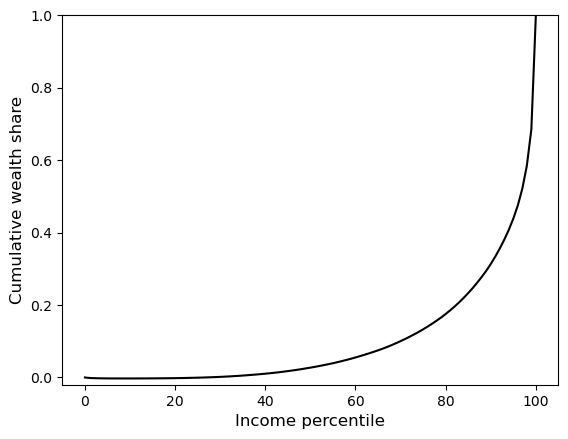

Estimate is center=1.0106872026726113, spread=0.010839333921286044
Lorenz distance is 2.0357178714676016
Average MPC for all consumers is 0.261
Average MPC in the top percentile of W/Y is 0.063
Average MPC in the top decile of W/Y is 0.065
Average MPC in the top quintile of W/Y is 0.068
Average MPC in the second quintile of W/Y is 0.089
Average MPC in the middle quintile of W/Y is 0.217
Average MPC in the fourth quintile of W/Y is 0.347
Average MPC in the bottom quintile of W/Y is 0.582
Average MPC in the top percentile of y is 0.223
Average MPC in the top decile of y is 0.232
Average MPC in the top quintile of y is 0.236
Average MPC in the second quintile of y is 0.264
Average MPC in the middle quintile of y is 0.271
Average MPC in the fourth quintile of y is 0.241
Average MPC in the bottom quintile of y is 0.291
Average MPC for the employed is 0.249
Average MPC for the unemployed is 0.411
Average MPC for the retired is nan
Of the population with the 1/3 highest MPCs...
51.157% are in

In [8]:
options = {
    "param_name": param_name,
    "dist_type": dist_type,
    "run_estimation": run_estimation,
    "run_sensitivity": run_sensitivity,
    "find_beta_vs_KY": find_beta_vs_KY,
    "do_tractable": do_tractable,
    "do_param_dist": do_param_dist,
    "do_lifecycle": do_lifecycle,
    "do_agg_shocks": do_agg_shocks,
    "do_liquid": do_liquid,
    "do_combo_estimation": True,
}


EstimationEconomy = estimate(options, parameters)

In [9]:
# Construct the Lorenz curves and plot them

pctiles = np.linspace(0.001, 0.999, 15)
SCF_Lorenz_points = get_lorenz_shares(
    SCF_wealth, weights=SCF_weights, percentiles=pctiles
)


sim_wealth_2 = np.concatenate(EstimationEconomy.reap_state["aLvl"])
sim_Lorenz_points_2 = get_lorenz_shares(sim_wealth_2, percentiles=pctiles)



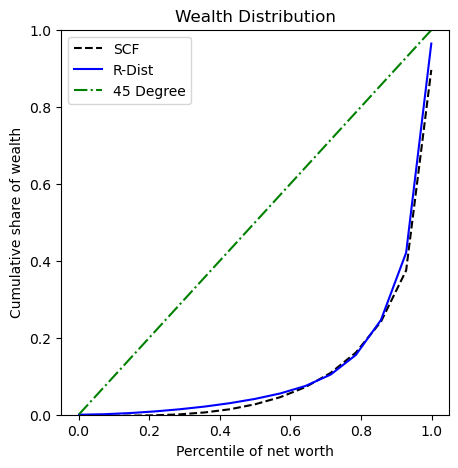

In [10]:
# Plot
plt.figure(figsize=(5, 5))
plt.title("Wealth Distribution")
plt.plot(pctiles, SCF_Lorenz_points, "--k", label="SCF")
plt.plot(pctiles, sim_Lorenz_points_2, "-b", label="R-Dist")
plt.plot(pctiles, pctiles, "g-.", label="45 Degree")
plt.xlabel("Percentile of net worth")
plt.ylabel("Cumulative share of wealth")
plt.legend(loc=2)
plt.ylim([0, 1])
plt.show("wealth_distribution_2")

In [11]:
MyGuys_First = EstimationEconomy.agents[0]
MyGuys_First.check_conditions()
print(MyGuys_First.bilt["conditions_report"])

β=0.99000 : intertemporal discount factor (DiscFac)
R=1.00042 : risk free interest factor (Rfree)
G=1.00000 : permanent income growth factor (PermGroFac)
ρ=1.01000 : coefficient of relative risk aversion (CRRA)
ℒ=0.99375 : survival probability (LivPrb)
Þ=(βℒR)^(1/ρ)=0.98438 : absolute patience factor (APFac)
℘=0.01400 : probability of worst income shock realization (WorstPrb)

APFac=0.98438 : The Absolute Patience Factor satisfies the Absolute Impatience Condition (AIC) Þ < 1.
RPFac=0.98397 : The Return Patience Factor satisfies the Return Impatience Condition (RIC) Þ/R < 1.
WRPFac=0.01437 : The Weak Return Patience Factor satisfies the Weak Return Impatience Condition (WRIC) ℘ Þ/R < 1.
GPFacRaw=0.98438 : The Growth Patience Factor satisfies the Growth Impatience Condition (GICRaw) Þ/G < 1.
GPFacMod=0.98759 : The Risk-Modified Growth Patience Factor satisfies the Risk-Modified Growth Impatience Condition (GICMod) Þ/(G‖Ψ‖_(-1)) < 1.
GPFacLiv=0.97823 : The Mortality-Adjusted Growth Patie

In [12]:
MyGuys_Last= EstimationEconomy.agents[-1]
MyGuys_Last.check_conditions()
print(MyGuys_Last.bilt["conditions_report"])

β=0.99000 : intertemporal discount factor (DiscFac)
R=1.02096 : risk free interest factor (Rfree)
G=1.00000 : permanent income growth factor (PermGroFac)
ρ=1.01000 : coefficient of relative risk aversion (CRRA)
ℒ=0.99375 : survival probability (LivPrb)
Þ=(βℒR)^(1/ρ)=1.00439 : absolute patience factor (APFac)
℘=0.01400 : probability of worst income shock realization (WorstPrb)

APFac=1.00439 : The Absolute Patience Factor violates the Absolute Impatience Condition (AIC) Þ < 1.
RPFac=0.98377 : The Return Patience Factor satisfies the Return Impatience Condition (RIC) Þ/R < 1.
WRPFac=0.01437 : The Weak Return Patience Factor satisfies the Weak Return Impatience Condition (WRIC) ℘ Þ/R < 1.
GPFacRaw=1.00439 : The Growth Patience Factor violates the Growth Impatience Condition (GICRaw) Þ/G < 1.
GPFacMod=1.00767 : The Risk-Modified Growth Patience Factor violates the Risk-Modified Growth Impatience Condition (GICMod) Þ/(G‖Ψ‖_(-1)) < 1.
GPFacLiv=0.99811 : The Mortality-Adjusted Growth Patience

## Comparing the Estimation to Data on the Rate of Return

First, we present the graph of the estimated distribution of the rate of return across households which minimizes the Lorenz distance, given the empirical targets for wealth levels from the SCF data.

1.0215265365938972
0.9998478687513253


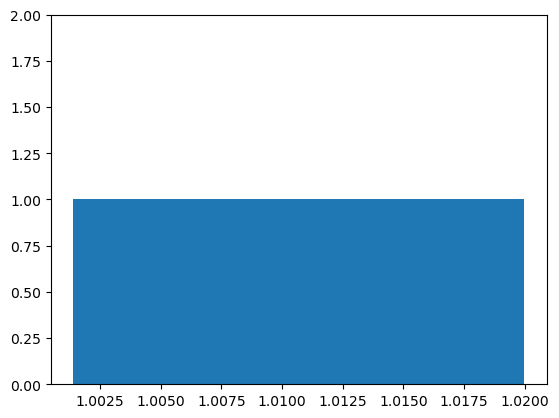

{'Mean': 1.0106872026726113,
 'Standard Deviation': 0.0062580923572907125,
 'Skewness': 0,
 'Kurtosis': -1.2}

In [13]:
import re

from code.estimateduniformstats import EstUniformDist

PYUnif_RDist = EstUniformDist("/Users/dc/Library/CloudStorage/OneDrive-JohnsHopkins/research/GitHub-forks/econ-ark/DistributionOfWealthMPC/DistributionOfWealthMPC/code/results/PYUnifrrateDistIndNetWorthResults.txt")

print(PYUnif_RDist.top)
print(PYUnif_RDist.bottom)

PYUnif_RDist.graph()

PYUnif_RDist.show_moments()

### Graph of the empirical distribution of safe and risky returns from Fagereng et al. (2015)

![Image Description](/Users/dc/Library/CloudStorage/OneDrive-JohnsHopkins/research/GitHub-forks/econ-ark/DistributionOfWealthMPC/DistEmpReturnsFagereng.png)

